In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip3 install pickle5
import pickle5 as pickle
!pip3 install --upgrade pandas==1.3.4
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

from google.colab import drive
drive.mount('/content/drive')

!ls drive/'My Drive'

drive_path = 'drive/My Drive/'
drive_path = 'drive/MyDrive/Deep Learning/Lira'

     |████████████████████████████████| 256 kB 4.2 MB/s 
     |████████████████████████████████| 11.3 MB 4.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
with open(drive_path+'/Copy of dataset_smol_boi.pickle', 'rb') as f:
    data_org = pickle.load(f)

In [ ]:

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# train_dataset = moving_average(data['GM.acc.xyz.z'][8],10)

# test_dataset = moving_average(data['GM.acc.xyz.z'][1615],10)

train_dataset = [[],[]]
test_dataset = [[],[]]
iri_mean = []
data = data_org['train']
data = data.sort_values(by=['IRI_mean'])

for i in range(int(len(data['IRI_Sequence']))):
    mean = np.mean(data['IRI_Sequence'].iloc[i])
    iri_mean.append(mean)
    if mean <5:
        train_dataset[0].append(mean)
        train_dataset[1].append(data['z_smooth'].iloc[i])
    elif mean > 5:
        test_dataset[0].append(mean)
        test_dataset[1].append(data['z_smooth'].iloc[i])

train_np = np.asarray(train_dataset,dtype=object).T
test_np = np.asarray(test_dataset,dtype=object).T
df_train = pd.DataFrame(np.asarray(train_dataset,dtype=object).T,columns=['iri','z'])

num_batches_train = len(df_train)

In [ ]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

print('train dataset',train_np.shape)
lstm_df_train = pd.DataFrame([np.append(*row) for row in train_np])
# lstm_df_train = lstm_df_train.drop(lstm_df_train.columns[1], axis=1)
print(lstm_df_train.shape)
lstm_df_train = lstm_df_train.loc[:,1:]
train_dataset, seq_len, n_features = create_dataset(lstm_df_train)
print('test dataset',lstm_df_train.shape)
lstm_df_test = pd.DataFrame([np.append(*row) for row in test_np])
# lstm_df_test = lstm_df_test.drop(lstm_df_test.columns[1], axis=1)
lstm_df_test = lstm_df_test.loc[:,1:]
print(lstm_df_test.shape)
test_dataset, seq_len_test, n_features_test = create_dataset(lstm_df_test)



train dataset (1192, 2)
(1192, 3066)
test dataset (1192, 3065)
(184, 3065)


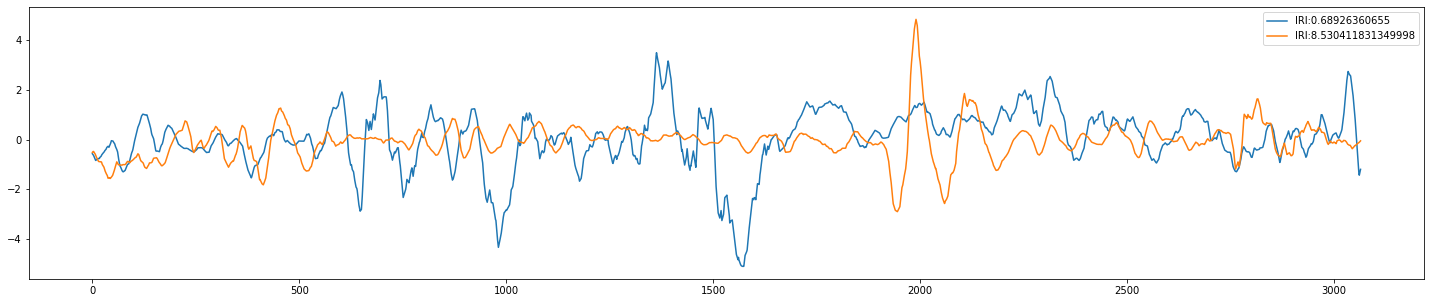

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_dataset[1])
plt.plot(test_dataset[-1])
plt.legend(['IRI:' + str(train_np[1,0]),'IRI:' + str(test_np[-1,0])])

In [ ]:
# working model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.seq_len = seq_len
        self.lstm1 = nn.LSTM(1, 100, 1, batch_first = True)
        self.lstm2 = nn.LSTM(100, 50, 1, batch_first = True)
        self.lstm3 = nn.LSTM(50, 100, 1, batch_first = True)
        
        self.l_out = nn.Linear(in_features=100,
                            out_features=1,
                            bias=False)
        
    def forward(self, x):
        x, (h, _) = self.lstm1(x)
        x, (h, _) = self.lstm2(x)
        x, (h, _) = self.lstm3(x)
        
        x = x.view(-1, self.lstm3.hidden_size)        
        x = self.l_out(x)
        
        return x

model = Autoencoder()

model = model.to(device)
print(model)


Autoencoder(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 100, batch_first=True)
  (l_out): Linear(in_features=100, out_features=1, bias=False)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3065, 1])) that is different to the input size (torch.Size([3065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 1.279131531715393
Epoch 2: train loss 1.2755882740020752
Epoch 3: train loss 1.271979808807373
Epoch 4: train loss 1.268256425857544
Epoch 5: train loss 1.2643712759017944
Epoch 6: train loss 1.2602710723876953
Epoch 7: train loss 1.2558976411819458
Epoch 8: train loss 1.2511881589889526
Epoch 9: train loss 1.2460741996765137
Epoch 10: train loss 1.240479588508606
Epoch 11: train loss 1.2343209981918335
Epoch 12: train loss 1.2275052070617676
Epoch 13: train loss 1.219929814338684
Epoch 14: train loss 1.2114814519882202
Epoch 15: train loss 1.2020343542099
Epoch 16: train loss 1.1914479732513428
Epoch 17: train loss 1.1795642375946045
Epoch 18: train loss 1.1662043333053589
Epoch 19: train loss 1.151166558265686
Epoch 20: train loss 1.1342228651046753
Epoch 21: train loss 1.1151165962219238
Epoch 22: train loss 1.0935615301132202
Epoch 23: train loss 1.069239854812622
Epoch 24: train loss 1.0418050289154053
Epoch 25: train loss 1.0108882188796997
Epoch 26: train los

Text(0.5, 1.0, 'LSTM Autoencoder')

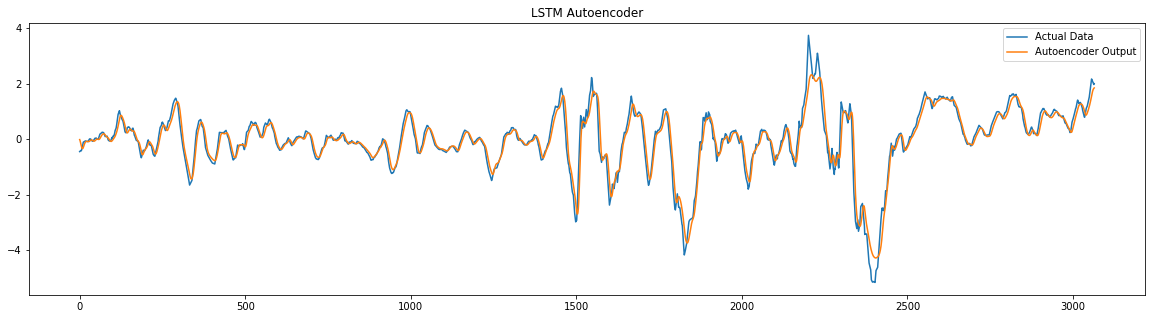

In [ ]:
# LSTM 100m
        
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_loss = 10000.0
  output = []
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []      
    optimizer.zero_grad()
    seq_true = torch.Tensor(train_np[0,1]).cuda()
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
    if(epoch == n_epochs):
      output.append(seq_pred.cpu().detach().numpy())
  return model.eval(), history, output

model, history, pred = train_model(
  model,
  train_dataset,
  n_epochs=100
)


plt.figure(figsize=[20,5])
plt.plot(train_np[0,1][:])
plt.plot(pred[0])
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

In [ ]:
path = drive_path + f'/Lira_final.pth'
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3065, 1])) that is different to the input size (torch.Size([3065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 0.0705510598721921
Epoch 2: train loss 0.001902468457666335
Epoch 3: train loss 0.0010209349722348049
Epoch 4: train loss 0.0007930553548464937
Epoch 5: train loss 0.0005192907404564084
Epoch 6: train loss 0.00046465936812618017
Epoch 7: train loss 0.0005061390433449226
Epoch 8: train loss 0.00019579220504632966
Epoch 9: train loss 0.00018185519085524247
Epoch 10: train loss 0.0003374651816225543
Epoch 11: train loss 0.00022414231544275084
Epoch 12: train loss 0.00020334390022016475
Epoch 13: train loss 0.00014254855458043078
Epoch 14: train loss 0.00020259026759462755
Epoch 15: train loss 0.0001026465357326667


Text(0.5, 1.0, 'LSTM Autoencoder')

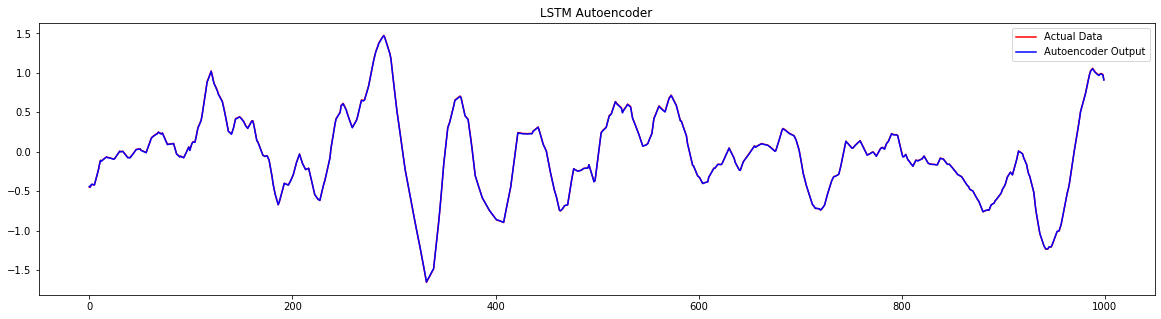

In [ ]:
# LSTM all 100m
def train_model(model, train_dataset, n_epochs):
  model_out = np.asarray([])
  model_in = np.asarray([])
  recon_loss_train = []
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  #criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    i = 0
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_true = seq_true.reshape((1, seq_len, 1))
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      if epoch == n_epochs:
        model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(seq_len,))))
        model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
        recon_loss_train.append(loss.item())
      i+=1
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train

model, history, model_out, model_in, recon_loss_train = train_model(
  model,
  train_dataset,
  n_epochs=15
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

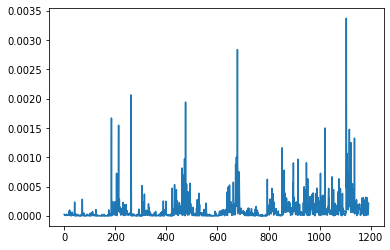

In [ ]:
plt.figure()
plt.plot(recon_loss_train)

In [ ]:
path = drive_path + f'/Lira_final_big.pth'
torch.save(model.state_dict(), path)

0.00014414696488529444


Text(0.5, 1.0, 'LSTM Autoencoder - Test')

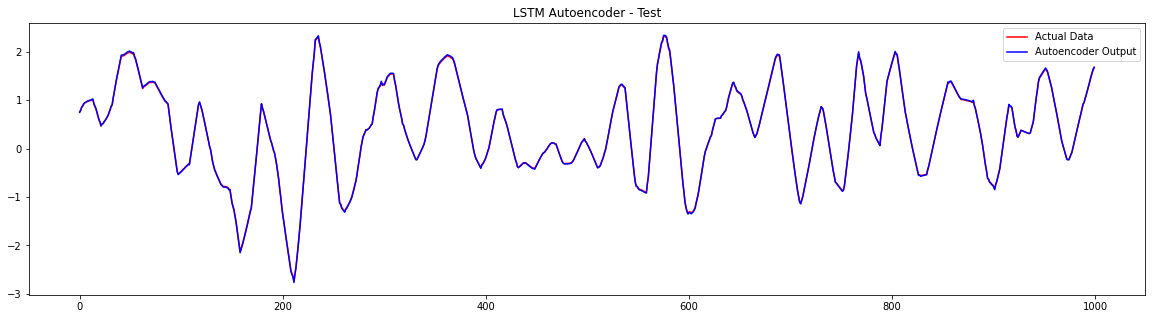

In [ ]:
# Test Dataset
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

seq_true = test_dataset[-1]
seq_true = seq_true.to(device)
seq_true1 = seq_true.reshape((1, seq_len, 1))
seq_pred = model(seq_true1)
loss = criterion(seq_pred, seq_true)
print(loss.item())

plt.figure(figsize=(20,5))
plt.plot(seq_true.cpu()[:1000],'r')
plt.plot(seq_pred.cpu().detach().numpy()[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder - Test')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3065, 1])) that is different to the input size (torch.Size([3065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Seq 1: test loss 0.00016214780043810606
Seq 2: test loss 0.00022168354189489037
Seq 3: test loss 0.00016375120321754366
Seq 4: test loss 0.00012946774950250983
Seq 5: test loss 8.925156726036221e-05
Seq 6: test loss 0.0001649360783630982
Seq 7: test loss 7.861668564146385e-05
Seq 8: test loss 9.896117262542248e-05
Seq 9: test loss 7.939345232443884e-05
Seq 10: test loss 0.00022568444546777755
Seq 11: test loss 0.0001314518303843215
Seq 12: test loss 0.00013606141146738082
Seq 13: test loss 0.00020446769485715777
Seq 14: test loss 0.00012897657870780677
Seq 15: test loss 8.248286758316681e-05
Seq 16: test loss 0.0001656972017372027
Seq 17: test loss 0.00012319255620241165
Seq 18: test loss 3.397353066247888e-05
Seq 19: test loss 0.00012880373105872422
Seq 20: test loss 0.0001725128386169672
Seq 21: test loss 0.00012605705705936998
Seq 22: test loss 8.213855471694842e-05
Seq 23: test loss 0.00012611014244612306
Seq 24: test loss 6.754764035576954e-05
Seq 25: test loss 0.00013398281589616

Text(0.5, 1.0, 'LSTM Autoencoder')

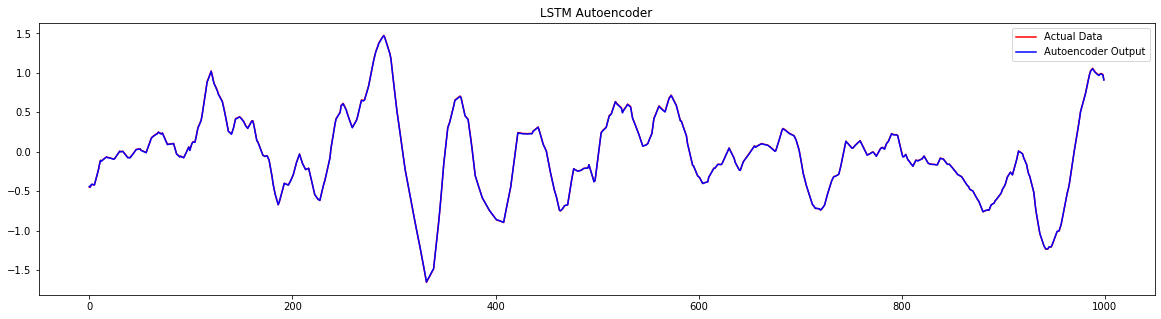

In [ ]:
def test_model(model, test_dataset):
  model_out = np.asarray([])
  model_in = np.asarray([])
  recon_loss_test = []
  criterion = nn.MSELoss()
  history = dict(test=[], val=[])
  test_losses = []
  seq = 0
  for seq_true in test_dataset:
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    test_losses.append(loss.item())
    model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(seq_len,))))
    model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
    recon_loss_test.append(loss.item())

    history['test'].append(test_losses)
    seq +=1
    print(f'Seq {seq}: test loss {loss.item()}')
  return model.eval(), history, model_out, model_in, recon_loss_test

model_test, history_test, model_out_test, model_in_test, recon_loss_test = test_model(
  model,
  test_dataset
)

plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

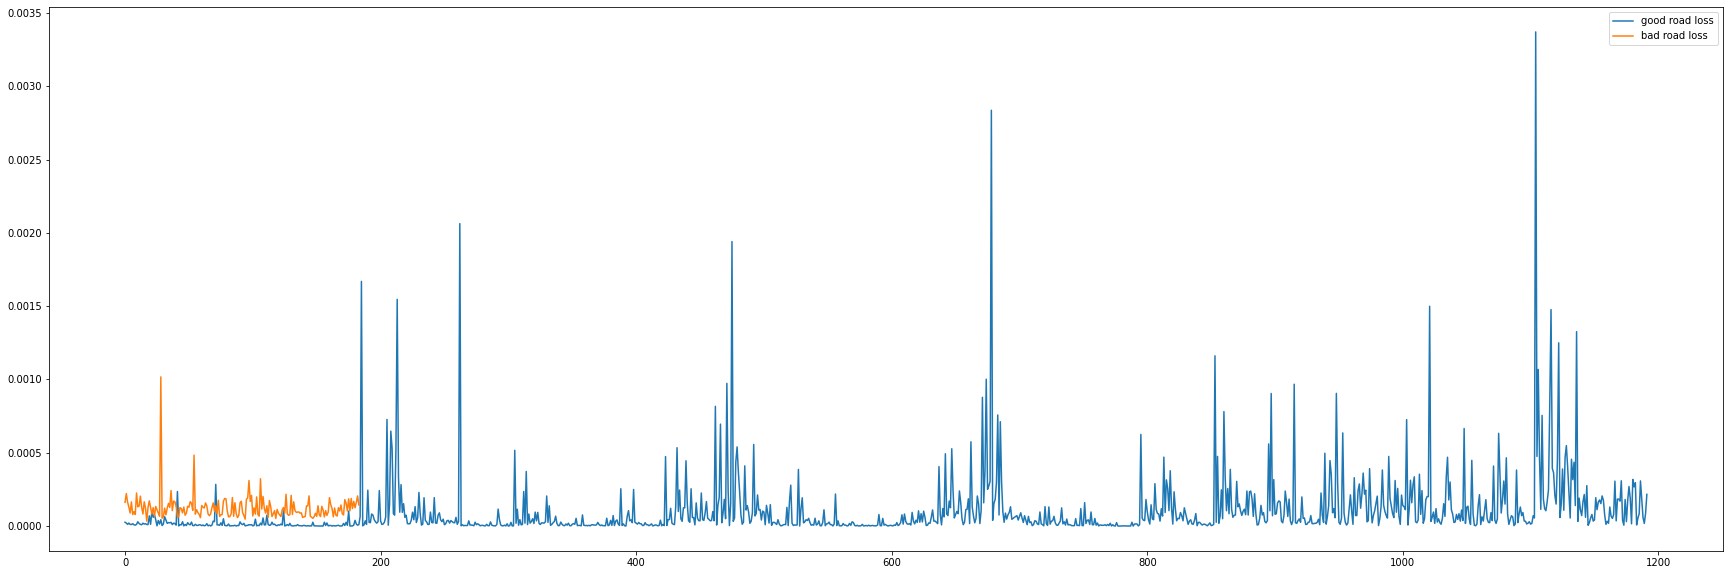

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(recon_loss_train)
plt.plot(recon_loss_test)
plt.legend(['good road loss','bad road loss'])

In [ ]:
class_good = np.zeros(len(recon_loss_train))
class_bad = np.ones(len(recon_loss_test))
targets = np.concatenate((class_good,class_bad))
data_loss = np.concatenate((recon_loss_train,recon_loss_test))

df_loss = np.stack((data_loss,targets),axis=1)
df_loss = pd.DataFrame(df_loss,columns=['data','target'])

In [ ]:
# LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    # print(self.seq_len, self.n_features, self.embedding_dim, self.hidden_dim)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim,1))


class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    print(x.size())
    x = self.encoder(x)
    print(x.size())
    x = self.decoder(x)
    return x

LEARNING_RATE = 3e-4
criterion = nn.MSELoss()   #<-- Your code here.   

BATCH_SIZE = 100
model = RecurrentAutoencoder(seq_len, n_features, 100)
model = model.to(device)
print(model)
print(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 200, batch_first=True)
    (rnn2): LSTM(200, 100, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(100, 100, batch_first=True)
    (rnn2): LSTM(100, 200, batch_first=True)
    (output_layer): Linear(in_features=200, out_features=1, bias=True)
  )
)
cuda


In [ ]:
# LSTM 100m
        
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_loss = 10000.0
  output = []
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []      
    optimizer.zero_grad()
    seq_true = torch.Tensor(train_np[0,1]).cuda()
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
    if(epoch == n_epochs):
      output.append(seq_pred.cpu().detach().numpy())
  return model.eval(), history, output

model, history, pred = train_model(
  model,
  train_dataset,
  n_epochs=100
)


plt.figure(figsize=[20,5])
plt.plot(train_np[0,1][:])
plt.plot(pred[0])
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

torch.Size([1, 3065, 1])
torch.Size([1, 100, 1])


RuntimeError: ignored

In [ ]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1 = torch.nn.Linear(1,20)
        self.linear2 = torch.nn.Linear(20,10)
        self.linear3 = torch.nn.Linear(10,1)
        self.relu = torch.nn.ReLU()   
        self.sm = torch.nn.Softmax()       
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(self.relu(x))
        return self.sm(self.linear3(self.relu(x)))


LEARNING_RATE = 3e-4
criterion = nn.MSELoss()   #<-- Your code here.   

model_classifier = Classifier()
model_classifier = model_classifier
print(model_classifier)

Classifier(
  (linear1): Linear(in_features=1, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sm): Softmax(dim=None)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 1.0
Epoch 2: train loss 1.0
Epoch 3: train loss 1.0
Epoch 4: train loss 1.0
Epoch 5: train loss 1.0
Epoch 6: train loss 1.0
Epoch 7: train loss 1.0
Epoch 8: train loss 1.0
Epoch 9: train loss 1.0
Epoch 10: train loss 1.0
Epoch 11: train loss 1.0
Epoch 12: train loss 1.0
Epoch 13: train loss 1.0
Epoch 14: train loss 1.0
Epoch 15: train loss 1.0
Epoch 16: train loss 1.0
Epoch 17: train loss 1.0
Epoch 18: train loss 1.0
Epoch 19: train loss 1.0
Epoch 20: train loss 1.0
Epoch 21: train loss 1.0
Epoch 22: train loss 1.0
Epoch 23: train loss 1.0
Epoch 24: train loss 1.0
Epoch 25: train loss 1.0
Epoch 26: train loss 1.0
Epoch 27: train loss 1.0
Epoch 28: train loss 1.0
Epoch 29: train loss 1.0
Epoch 30: train loss 1.0
Epoch 31: train loss 1.0
Epoch 32: train loss 1.0
Epoch 33: train loss 1.0
Epoch 34: train loss 1.0
Epoch 35: train loss 1.0
Epoch 36: train loss 1.0
Epoch 37: train loss 1.0
Epoch 38: train loss 1.0
Epoch 39: train loss 1.0
Epoch 40: train loss 1.0
Epoch 41:

Text(0.5, 1.0, 'LSTM Autoencoder')

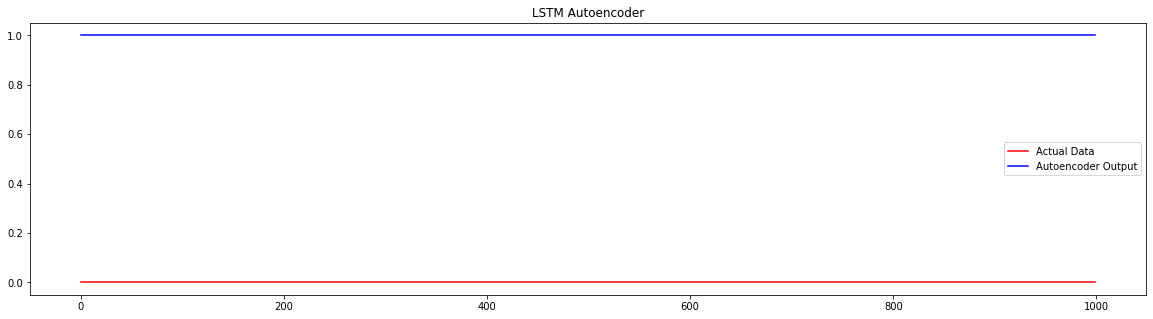

In [ ]:
def train_model_classifier(model, train_dataset, n_epochs):
  model_out = []
  model_in = []
  recon_loss_train = []
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for i in range(len(train_dataset)):
      optimizer.zero_grad()
      seq_true = torch.from_numpy(np.asarray(train_dataset['data'][i])).float()
      seq_pred = model(seq_true.unsqueeze(dim=0))
      # loss = criterion(seq_pred, torch.from_numpy(np.asarray(train_dataset['target'][i])).float())
      loss = criterion(seq_pred, torch.from_numpy(np.asarray(train_dataset['target'][i])).float())
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      if epoch == n_epochs:
        model_out.append(seq_pred.cpu().detach().numpy())
        model_in.append(train_dataset['target'][i])
        recon_loss_train.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return model.eval(), history, model_out, model_in, recon_loss_train

model_classifier, history_classifier, model_out_classifier, model_in_classifier, loss_train_classifier = train_model_classifier(
  model_classifier,
  df_loss[:1000],
  n_epochs=100
)

plt.figure(figsize=[20,5])
plt.plot(model_in_classifier,'r')
plt.plot(model_out_classifier,'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

In [ ]:

df_loss_shuffle = df_loss.sample(frac=1).reset_index(drop=True)

Train
Linear SVM accuracy: 85.33%
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0

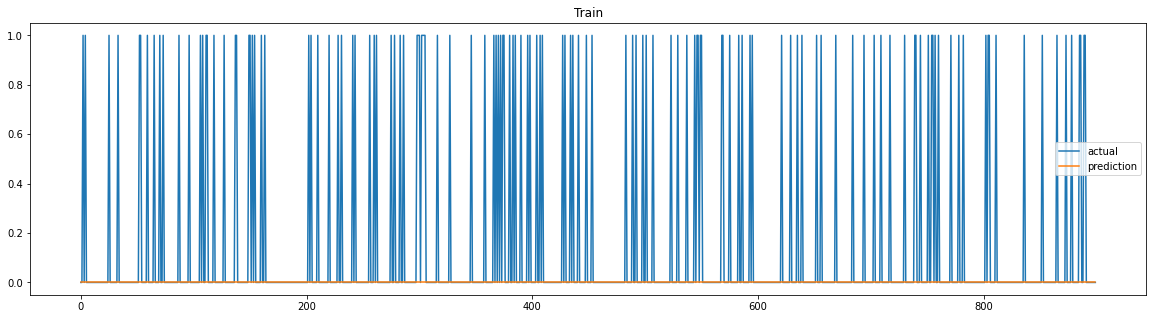

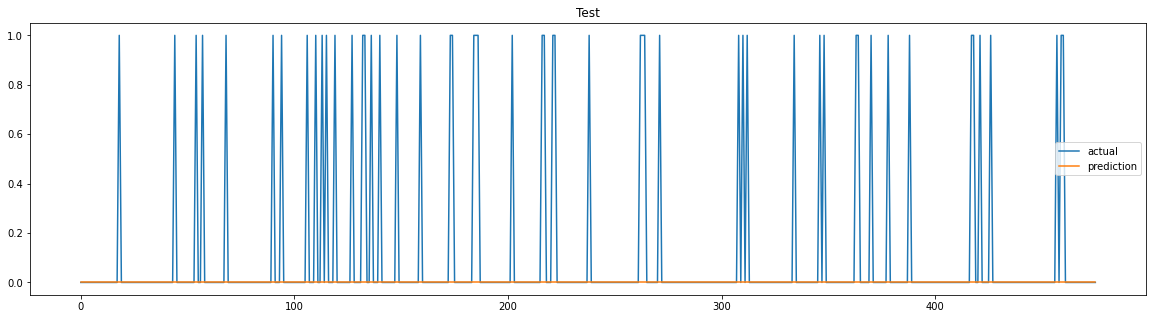

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
def fit_classifier(df_loss):
  limit = 900
  clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5,max_iter=1e5))
  X = np.array(df_loss['data'][:limit]).reshape(-1,1)
  y = df_loss['target'][:limit]
  clf.fit(X, y)
  score = clf.score(X, y)
  preds = clf.predict(X)
  print('Train')
  print(f"Linear SVM accuracy: {score*100:.2f}%")
  print(np.asarray(df_loss['target'][:limit]))
  print(preds)
  
  plt.figure(figsize=(20,5))
  plt.plot(np.asarray(df_loss['target'][:limit]))
  plt.plot(preds)
  plt.legend(['actual','prediction'])
  plt.title('Train')


  X_test = np.array(df_loss['data'][limit:]).reshape(-1,1)
  y_test = df_loss['target'][limit:]
  clf.fit(X_test, y_test)
  score_test = clf.score(X_test, y_test)
  preds_test = clf.predict(X_test)
  print('Test')
  print(f"Linear SVM accuracy: {score_test*100:.2f}%")
  print(np.asarray(df_loss['target'][limit:]))
  print(preds_test)
  
  plt.figure(figsize=(20,5))
  plt.plot(np.asarray(df_loss['target'][limit:]))
  plt.plot(preds_test)
  plt.legend(['actual','prediction'])
  plt.title('Test')

  return score,preds

score, predictions = fit_classifier(df_loss_shuffle)